In [15]:
from pylab import *
ion()

from numpy import *
import numpy as np
eig = linalg.eig
eigvals = linalg.eigvals
svd = linalg.svd
inv = linalg.inv
pinv = linalg.pinv
import time

import numba
from numba import njit

import scipy
from scipy import ndimage
gfilt =ndimage.gaussian_filter

resultsfile = "dataHan256/"
mfact = 2       #specifies size of the phantom image. The phantom image size will be (512/mfact)^2
cutoffparm = 4.0  # parameter for the sqrt-hanning filter

#load in a test image
imagenumber = 3  # selection range is 0 through 9
material = "Adipose"  # options are "Adipose", "Fibroglandular" and "Calcification"
phantom1 =load("Phantom_"+material+".npy")[imagenumber]
material = "Fibroglandular" 
phantom2 =load("Phantom_"+material+".npy")[imagenumber]
material = "Calcification" 
phantom3 =load("Phantom_"+material+".npy")[imagenumber]

testimage = (0.5*phantom1 + 1.0*phantom2 + 2.0*phantom3).astype("float64")   #Build our testimage
testimage = testimage[::mfact,::mfact]*1.

# searched optimal parameter settings for different phantom sizes
# 128, alpha=1.95 , beta = 10
# 256, alpha=1.9  , beta = 10
# 512, alpha=1.7  , beta = 5

addnoise = 0
nph = 1.e6
nuxfact = 0.5 #combination factor for x-gradient with projection matrix
nuyfact = 0.5 #combination factor for y-gradient with projection matrix
l1f = 1.0 #don't change this parameter yet
eps = 0.001 # data error constraint in terms of RMSE
larc = 1.0 #1.0 (if limited angular range)  or 0.0 (full 360 scan)
alpha = 1.75  #combination strength of x- and y- gradients
beta = 5.0
rho = 1.75 #over-relaxation parameter for He-Yuan predictor corrector

stepbalance = 100.0 # step-size ratio for CP, needs to be tuned 

In [16]:
#reduce phantom size
phimage = testimage*1.
testimage = phimage*0.
bpimage = testimage*0.

#image parameters
ximageside = 10.0   #cm
yimageside = 10.0   #cm
nx = int(512/mfact)
ny = int(512/mfact)
npix = nx*ny
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([ny])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
mask = phimage*0.
mask[rar<=ximageside/2.]=1.
#mask.fill(1.)

# sinogram parameters. Note that there are multiple names for some
# of the parameters. This is due to legacy code.
radius = 50.0    #cm
source_to_detector = 100.0   #cm
srad = radius
sd = source_to_detector
slen = (50./180.)*pi     #angular range of the scan
slen0 = -slen/2.0
ns0 = 25
nu0 = 1024
nviews = ns0   
nbins = nu0
nrays = nbins*nviews
epssc = eps*sqrt(nrays)


# The linear detector length is computed in the projection function so that it is
# the exact size needed to capture the projection of the largest inscribed circle in
# the image array.
fanangle2 = arcsin((ximageside/2.)/radius)  # This only works for ximageside = yimageside
detectorlength = 2.*tan(fanangle2)*source_to_detector
u0 = -detectorlength/2.

du = detectorlength/nbins
ds = slen/(nviews-larc)
dup = du*radius/source_to_detector  #detector bin spacing at iso-center

In [17]:
sinogram=zeros([nviews,nbins])

In [18]:
#@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
@njit
###############
def circularFanbeamProjection(image,sinogram, 
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = srad, source_to_detector = sd, detectorlength = detectorlength,
                              nviews = ns0, slen = slen, slen0 = slen0, nbins = nu0):


   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews-larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds+slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin = xDetCenter + eux*u
         ybin = yDetCenter + euy*u

         xl=x0
         yl=y0

         xdiff=xbin-xsource
         ydiff=ybin-ysource
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ysource+slope*(xl-xsource)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ysource+slope*(x-xsource)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*(iy if iy > iyOld else iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xsource+slopeinv*(yl-ysource)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xsource+slopeinv*(y-ysource)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*(ix if ix > ixOld else ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum
         

In [19]:
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularFanbeamBackProjection(sinogram, image,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = srad, source_to_detector = sd, detectorlength  = detectorlength,
                              nviews = ns0, slen = slen,slen0=slen0, nbins = nu0):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews - larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds + slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         sinoval = sinogram[sindex,uindex]
         u = u0+(uindex+0.5)*du
         xbin = xDetCenter + eux*u
         ybin = yDetCenter + euy*u

         xl=x0
         yl=y0

         xdiff=xbin-xsource
         ydiff=ybin-ysource
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ysource + slope*(xl-xsource)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ysource+slope*(x-xsource)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*(iy if iy > iyOld else iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xsource+slopeinv*(yl-ysource)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xsource+slopeinv*(y-ysource)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*(ix if ix > ixOld else ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept

In [20]:
@njit
###############
def circularFanbeamPDBackProjection(sinogram,image, fov_radius = ximageside/1.,
       nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
       radius = radius, source_to_detector = source_to_detector,
       nviews = nviews, slen = slen, slen0 = slen0, nbins = nbins, detectorlength = detectorlength):
# This implementation is for weighted pixel-driven back-projection needed for fan-beam FBP

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/(nviews -larc)

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds + slen0
# Location of the source
      xsource=radius*cos(s)
      ysource=radius*sin(s)

# detector center
      xDetCenter=(radius - source_to_detector)*cos(s)
      yDetCenter=(radius - source_to_detector)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)


      for iy in range(ny):
         pix_y = y0 + dy*(iy+0.5)
         for ix in range(nx):
            pix_x = x0 + dx*(ix+0.5)

            frad = sqrt(pix_x**2. + pix_y**2.)
            fphi = arctan2(pix_y,pix_x)
            if (frad<=fov_radius):

               ew_dot_source_pix = (pix_x-xsource)*ewx + (pix_y-ysource)*ewy        
               rayratio = -source_to_detector/ew_dot_source_pix

               det_int_x = xsource+rayratio*(pix_x-xsource)
               det_int_y = ysource+rayratio*(pix_y-ysource)

               upos = ((det_int_x-xDetCenter)*eux +(det_int_y-yDetCenter)*euy)
               if (upos-u0 >= du/2.) and (upos-u0 < detectorlength-du/2.):
                  bin_loc = (upos-u0)/du +0.5
                  nbin1 = int(bin_loc) -1
                  nbin2 = nbin1+1 
                  frac= bin_loc - int(bin_loc)
                  det_value=frac*sinogram[sindex,nbin2]+(1.-frac)*sinogram[sindex,nbin1]
               else:
                  det_value = 0.0

               image[ix,iy] += det_value*ds

In [21]:
def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Polar\AppData\Local\Temp\ipykernel_24860\3455665003.py:6: SyntaxWarning: invalid escape sequence '\s'
  min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0


In [22]:
def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w

In [23]:
#generate gradient matrix for directional TVs
gmatx = zeros([nx,nx])
for i in range(nx):
   gmatx[i,i] = -1.0
for i in range(nx-1):
   gmatx[i,i+1] = 1.0

gmaty = zeros([ny,ny])
for i in range(ny):
   gmaty[i,i] = -1.0
for i in range(ny-1):
   gmaty[i,i+1] = 1.0
def gradx(image):
   return dot(gmatx,image)
def grady(image):
   return array(dot(gmaty,image.T).T,order="C")
def mdivx(image):
   return dot(gmatx.T,image)
def mdivy(image):
   return array(dot(gmaty.T,image.T).T,order="C")

In [24]:
#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad

def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim

In [25]:
if 1==1:
   nb0 = nbins
   blen0 =  detectorlength
   db = blen0/nb0
   b00 = - blen0/2.
   uar = arange(b00 + db/2., b00 + blen0, db)*1.
   uhanp = abs(b00)/cutoffparm
   uhan = 0.5*(1.0 + cos(pi*uar/uhanp))
   uhan[abs(uar)>uhanp] = 0.
#   filterfun = abs(uar)*uhan
   filterfun = abs(uar)

def fo(sinom):
   imft = fft.fft(sinom,axis=1)
   pimft = (ones([nbins])*fft.fftshift(sqrt(filterfun)))*imft
   res = (1.*fft.ifft(pimft,axis=1).real)
   return res

In [26]:
#########BEGIN DATA GENERATION #############

truesino=sinogram*0.
circularFanbeamProjection(phimage,truesino)
#add noise
if addnoise:
   sinodata =-log(poisson(nph*exp(-truesino))/nph)
else:
   sinodata= truesino*1.

sinodata = fo(sinodata)

xgrad = gradx(phimage)
gim = sqrt(xgrad**2)
truetvx = gim.sum()

ygrad = grady(phimage)
gim = sqrt(ygrad**2)
truetvy = gim.sum()


xgrad,ygrad = gradim(phimage)
gim = sqrt(xgrad**2 + ygrad**2)
truetv = gim.sum() #calc true TV


# compute norm of X
xim = randn(nx,ny)
xim *= mask
npower = 50
worksino =truesino*0.
for i in range(npower):
   circularFanbeamProjection(xim,worksino)
   worksino = fo(worksino)
   xim.fill(0.)
   worksino = fo(worksino)
   circularFanbeamBackProjection(worksino,xim)
   xim *= mask
   xnorm2 = sqrt( (xim**2.).sum() )
   xim/=xnorm2
snorm = sqrt(xnorm2)
nusino = 1./snorm
print("nusino: ",nusino)
#xvec = xim*1.
input("hi")

# compute norm of Dx
xim = randn(nx,ny)
xim *= mask
npower = 50
for i in range(npower):
   xg = gradx(xim)
   xim.fill(0.)
   xim  = mdivx(xg)
   xim *= mask
   xnorm2 = sqrt( (xim**2.).sum() )
   xim/=xnorm2
gnorm = sqrt(xnorm2)
nuxgrad = nuxfact/gnorm
print("nuxgrad: ",nuxgrad)
#dxvec = xim*1.

tvxconstraint = 1.0*nuxgrad*truetvx

# compute norm of Dy
xim = randn(nx,ny)
xim *= mask
npower = 50
for i in range(npower):
   yg = grady(xim)
   xim.fill(0.)
   xim  = mdivy(yg)
   xim *= mask
   xnorm2 = sqrt( (xim**2.).sum() )
   xim/=xnorm2
gnorm = sqrt(xnorm2)
nuygrad = nuyfact/gnorm
print("nuygrad: ",nuygrad)

tvyconstraint = 1.0*nuygrad*truetvy

sinodatasc = nusino*sinodata

# compute total norm
xim = randn(nx,ny)
xim *= mask
xim1 = xim*0.
xim2 = xim*0.
npower = 200
worksino =truesino*0.
for i in range(npower):
   circularFanbeamProjection(xim,worksino)
   worksino = fo(worksino)
   worksino *= nusino
   xg = gradx(xim)
   xg *= nuxgrad

   yg = grady(xim)
   yg *= nuygrad

   yim = l1f*xim
   mag1 = sqrt((yim**2).sum() + (yg**2).sum() + (xg**2).sum() +(worksino**2).sum())
   yim /=mag1
   yg /=mag1
   xg /=mag1
   worksino/=mag1

   xim1.fill(0.)
   worksino = fo(worksino)
   circularFanbeamBackProjection(worksino,xim1)
   xim1 *= (nusino*mask)
   xim2  = mdivx(xg)
   xim2 *= (nuxgrad*mask)
   xim3  = mdivy(yg)
   xim3 *= (nuygrad*mask)
   xim =  xim1+xim2+xim3 +l1f*yim
   mag2 = sqrt( (xim**2.).sum() )
   xim/=mag2
   xim1.fill(0.)
   xim2.fill(0.)
   xim3.fill(0.)

   print(i, "mag1: ", mag1," mag2: ",mag2)

totalnorm = (mag1+mag2)*0.5
print("totalnorm: ",totalnorm)

nusino:  0.463319827604366
nuxgrad:  0.2506493737697885
nuygrad:  0.25065606495640436
0 mag1:  258.61601984211677  mag2:  1.1498488306134702
1 mag1:  1.1581882922960935  mag2:  1.166673228185638
2 mag1:  1.17530235026222  mag2:  1.1840773912170681
3 mag1:  1.1930008035922557  mag2:  1.2020730815186484
4 mag1:  1.2112900397524822  mag2:  1.2206404513732605
5 mag1:  1.2301044649860957  mag2:  1.2396531707757978
6 mag1:  1.2492495481991723  mag2:  1.2588508140101993
7 mag1:  1.2684119333445811  mag2:  1.2778898173494977
8 mag1:  1.2872475719339953  mag2:  1.2964581282406888
9 mag1:  1.3055066839719758  mag2:  1.3143915842100917
10 mag1:  1.323123515252629  mag2:  1.3317231191399457
11 mag1:  1.3402173229142185  mag2:  1.3486348040496383
12 mag1:  1.357001090059944  mag2:  1.3653338293058324
13 mag1:  1.3736387764510478  mag2:  1.3819070004139207
14 mag1:  1.3901137256012495  mag2:  1.398219042771668
15 mag1:  1.4061704782908864  mag2:  1.4139071249406048
16 mag1:  1.4213647763994128  mag2

Iter:  1  TVX:  0.0  :  1462.1581360343844  TVY:  0.0  :  1424.7765859607607  TV:  0.0  :  2365.855936721384
derr:  0.5744608535245849  ierr:  0.6031386655724844


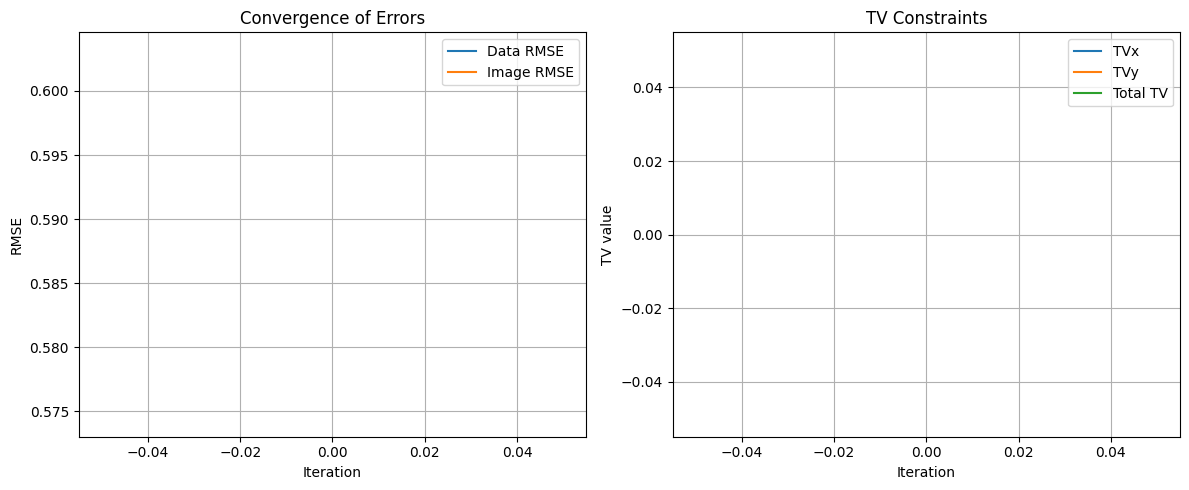

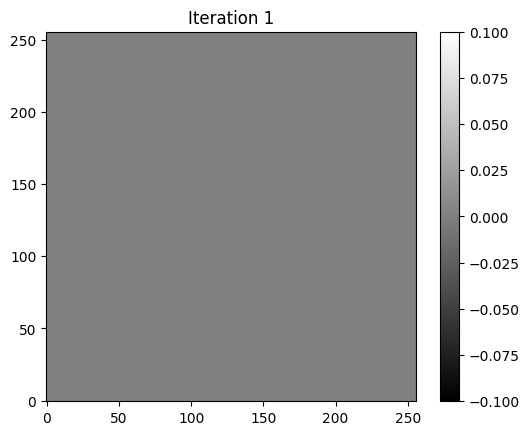

Iter:  2  TVX:  224.5738581111243  :  1462.1581360343844  TVY:  553.9282427100443  :  1424.7765859607607  TV:  648.022031692479  :  2365.855936721384
derr:  0.4894972295464128  ierr:  0.5324483372970763


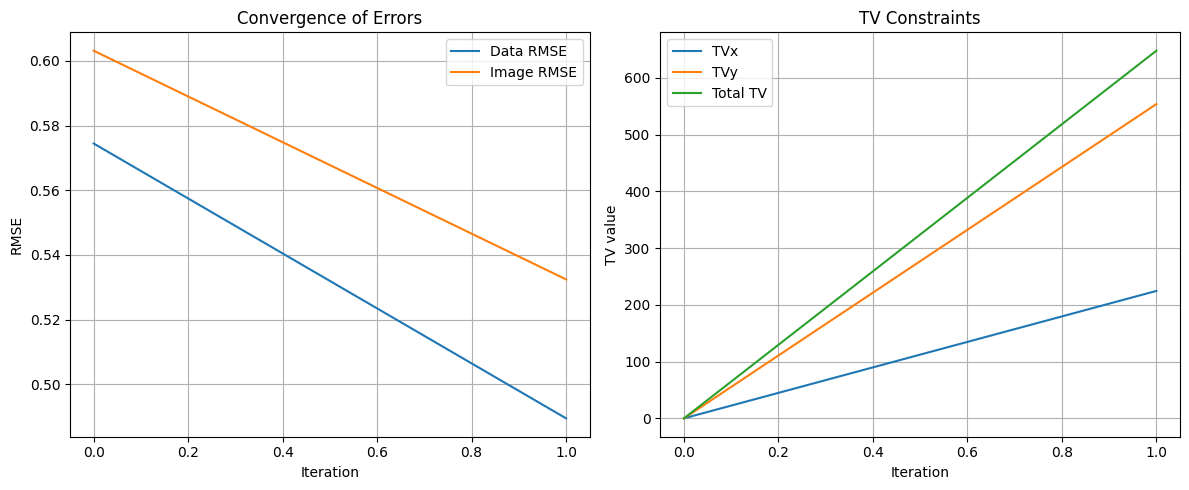

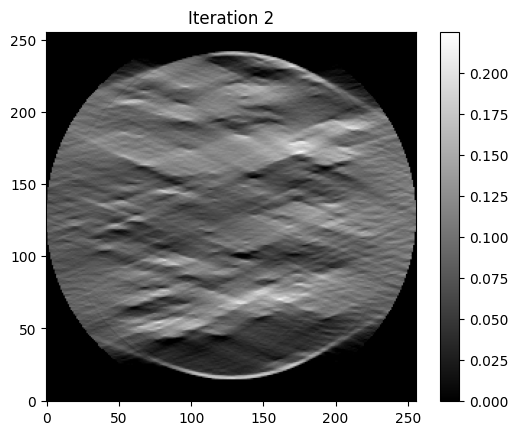

Iter:  5  TVX:  990.5507717848933  :  1462.1581360343844  TVY:  2240.702016303091  :  1424.7765859607607  TV:  2690.4333981022337  :  2365.855936721384
derr:  0.14864601187790744  ierr:  0.28146361936555964


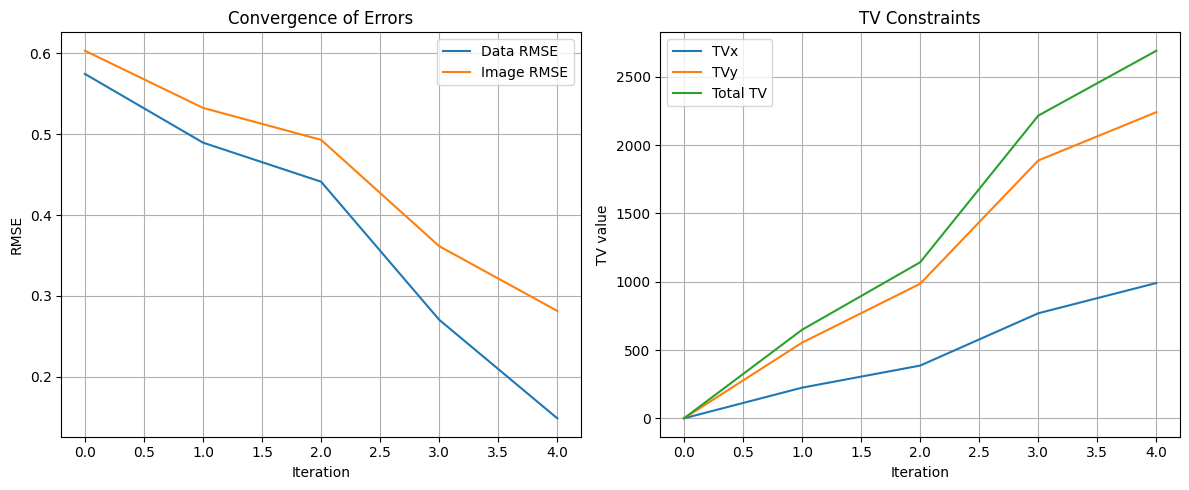

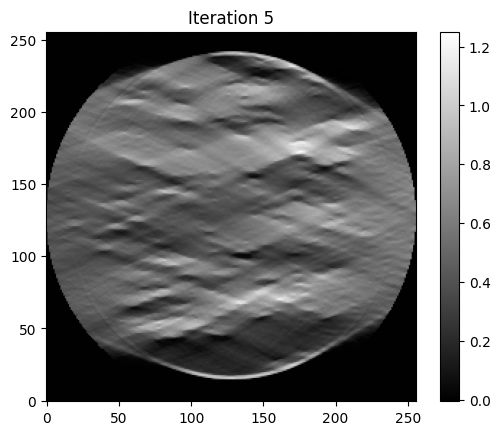

Iter:  10  TVX:  1957.3056025659826  :  1462.1581360343844  TVY:  2774.0346547111503  :  1424.7765859607607  TV:  3829.9383479566122  :  2365.855936721384
derr:  0.48902223792397803  ierr:  0.5262594943832622


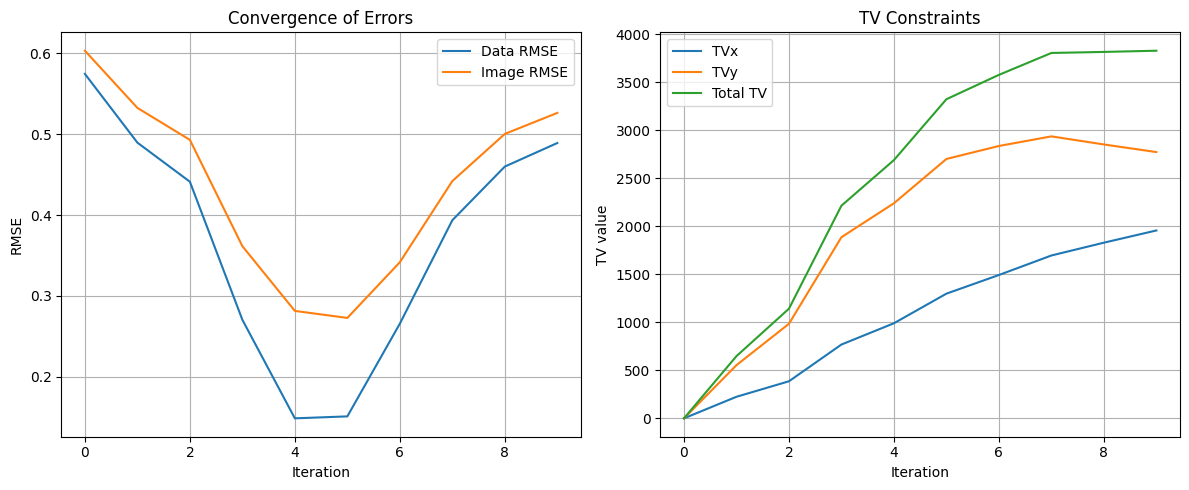

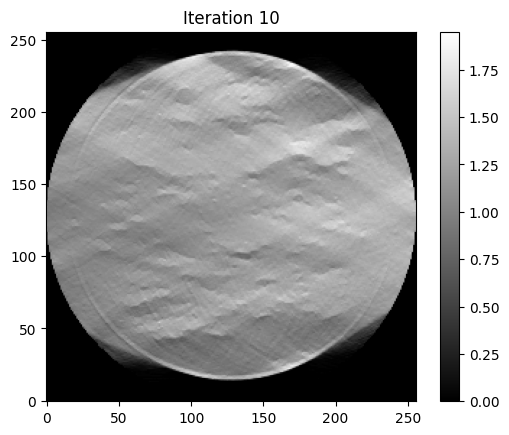

Iter:  20  TVX:  1820.6863745745218  :  1462.1581360343844  TVY:  2388.227219906255  :  1424.7765859607607  TV:  3367.3849463267934  :  2365.855936721384
derr:  0.3719834365084293  ierr:  0.41833531782113664


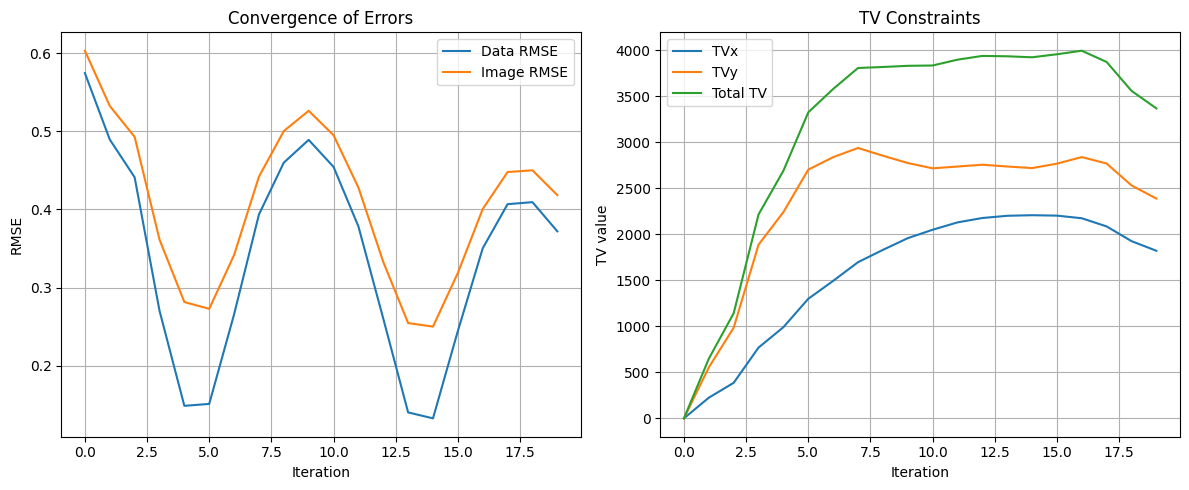

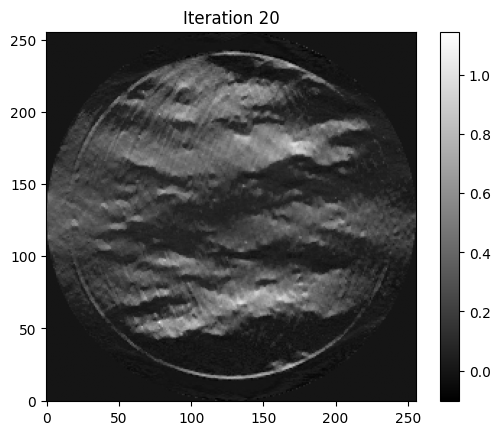

Iter:  50  TVX:  2506.5816239160613  :  1462.1581360343844  TVY:  2675.5381474952987  :  1424.7765859607607  TV:  4144.848242449142  :  2365.855936721384
derr:  0.06554510318605768  ierr:  0.16177714731686432


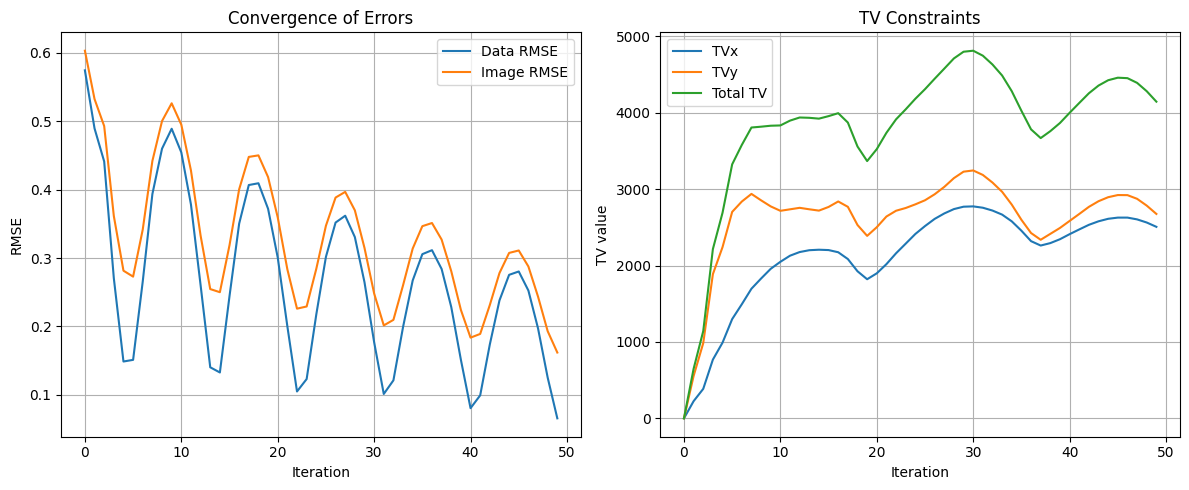

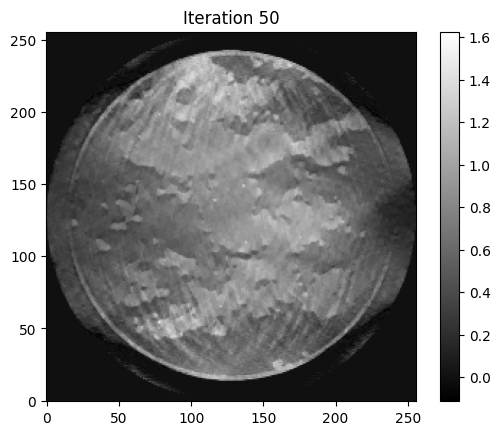

Iter:  100  TVX:  2073.805501582192  :  1462.1581360343844  TVY:  2175.6610028378323  :  1424.7765859607607  TV:  3429.507800404051  :  2365.855936721384
derr:  0.12340625150321642  ierr:  0.21845151029682428


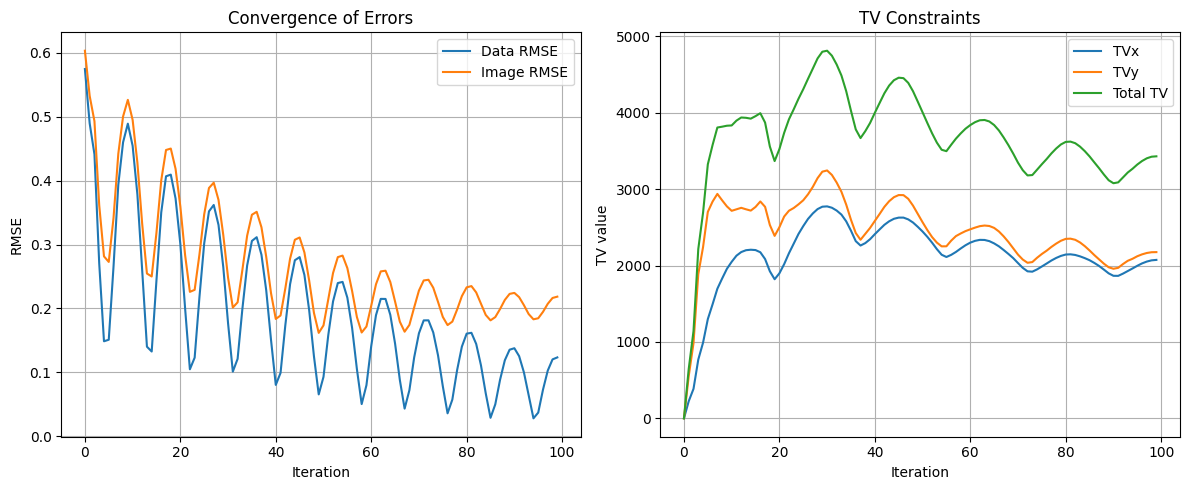

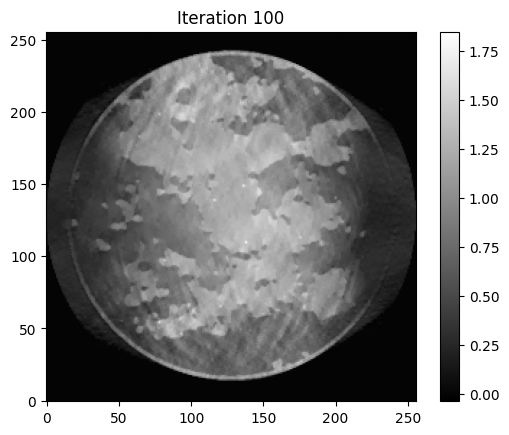

Iter:  200  TVX:  1850.8090098839843  :  1462.1581360343844  TVY:  1738.712535245039  :  1424.7765859607607  TV:  2951.9013168242554  :  2365.855936721384
derr:  0.0365524386657756  ierr:  0.1731503401434612


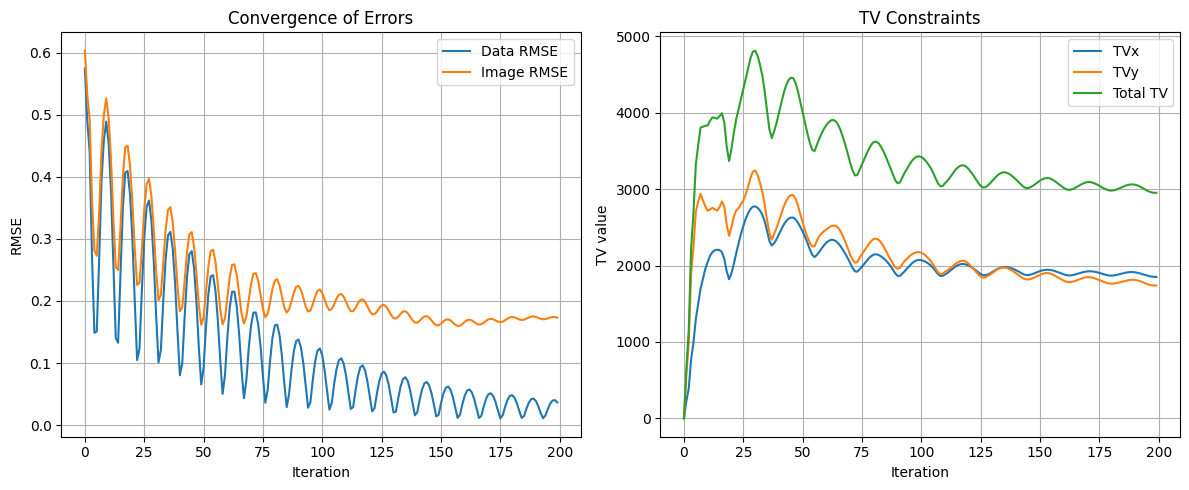

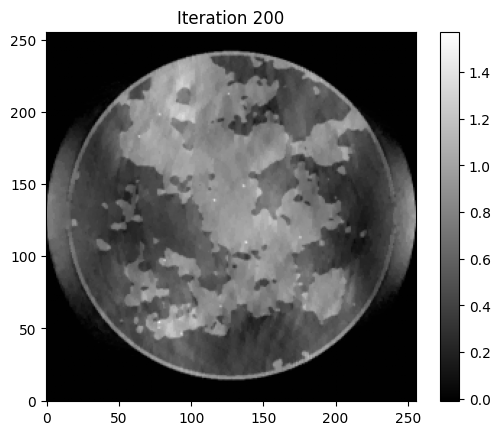

Iter:  300  TVX:  1653.3823340976003  :  1462.1581360343844  TVY:  1619.9488191229202  :  1424.7765859607607  TV:  2696.2214766327215  :  2365.855936721384
derr:  0.010605828464253151  ierr:  0.13966807591086458


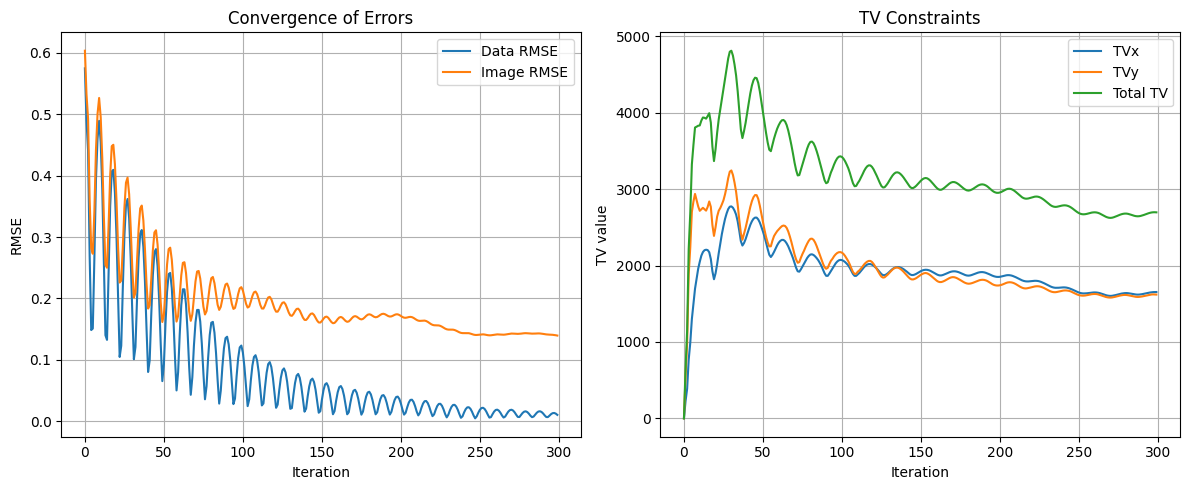

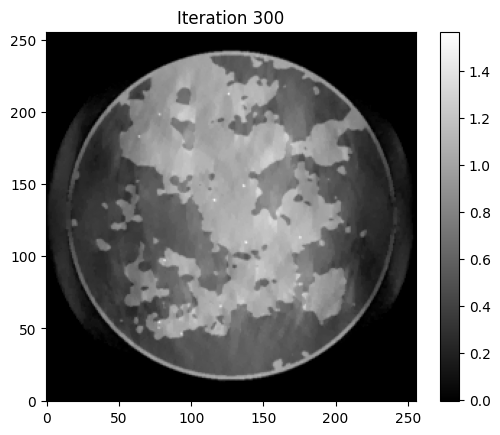

Iter:  400  TVX:  1630.179006919427  :  1462.1581360343844  TVY:  1611.3040170581962  :  1424.7765859607607  TV:  2673.8212237889193  :  2365.855936721384
derr:  0.0036204349228422957  ierr:  0.11024706035888472


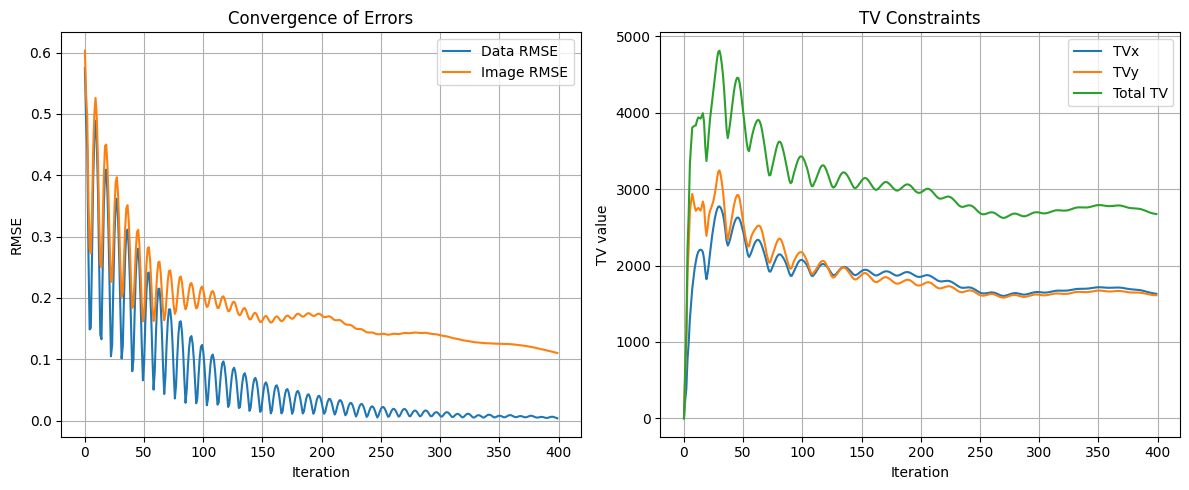

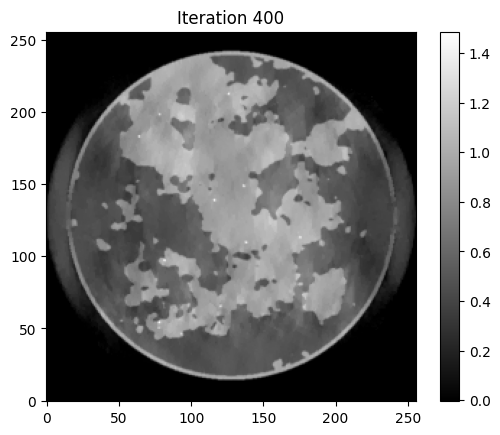

Iter:  500  TVX:  1543.9826812209958  :  1462.1581360343844  TVY:  1529.9127226651813  :  1424.7765859607607  TV:  2539.572196406526  :  2365.855936721384
derr:  0.0021128423229982525  ierr:  0.09200070448406829


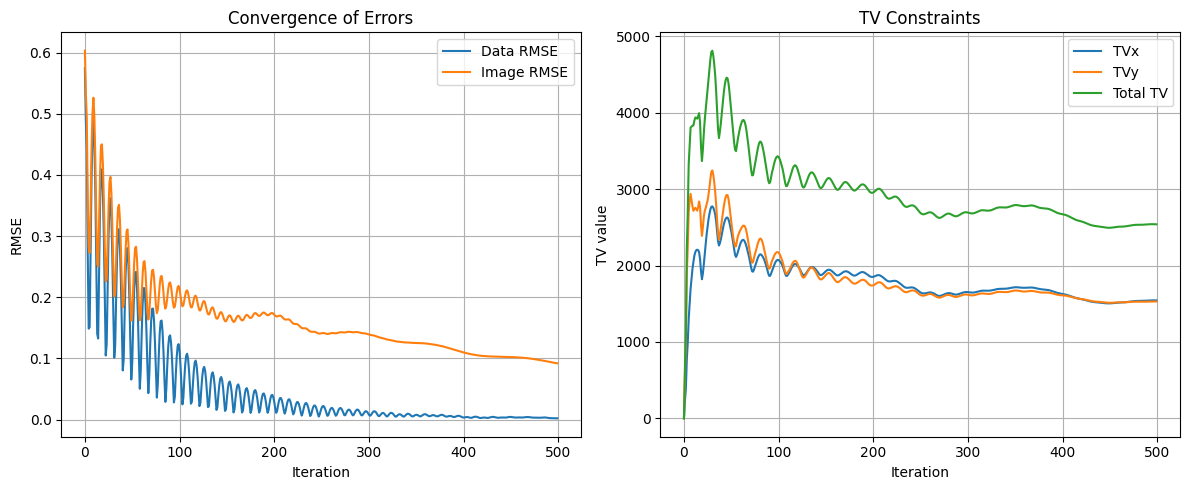

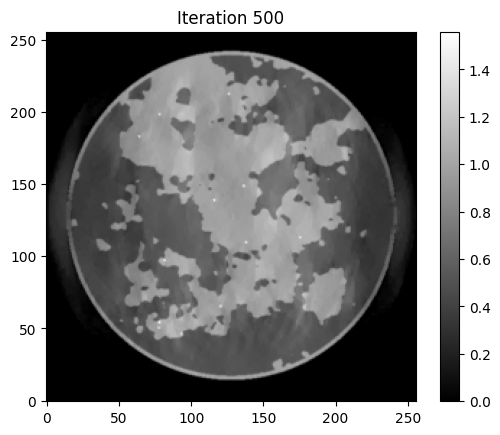

Iter:  600  TVX:  1458.5977259384695  :  1462.1581360343844  TVY:  1475.9630380632211  :  1424.7765859607607  TV:  2424.545734342944  :  2365.855936721384
derr:  0.0011056408481257653  ierr:  0.07346276883292917


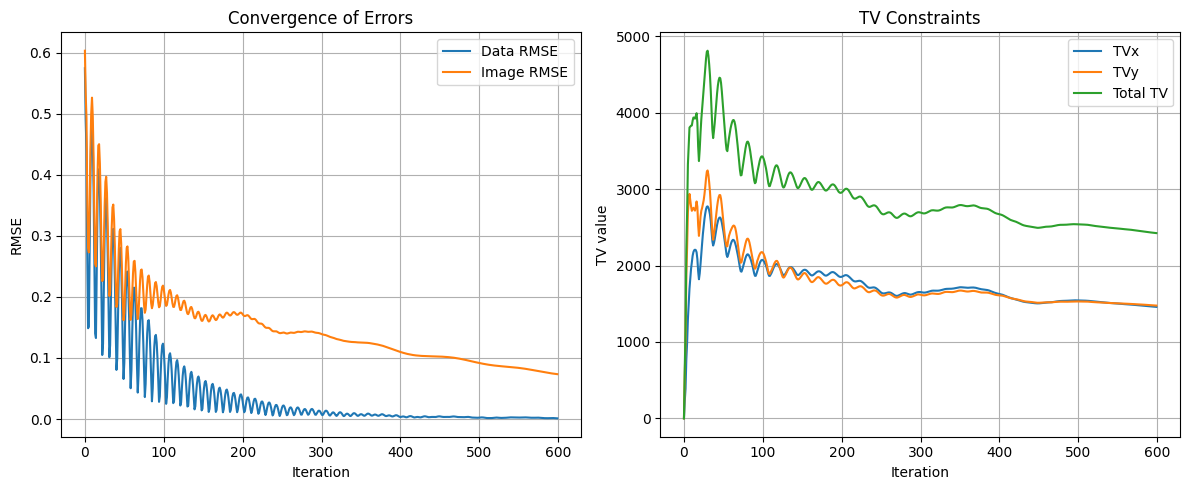

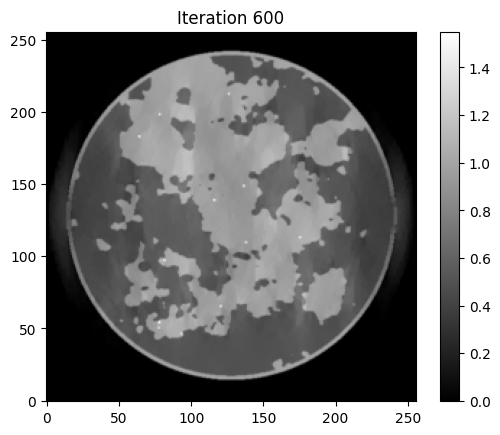

Iter:  700  TVX:  1446.6115023428383  :  1462.1581360343844  TVY:  1463.8998707658109  :  1424.7765859607607  TV:  2402.7535597147225  :  2365.855936721384
derr:  0.0013148236715374078  ierr:  0.0625525102757582


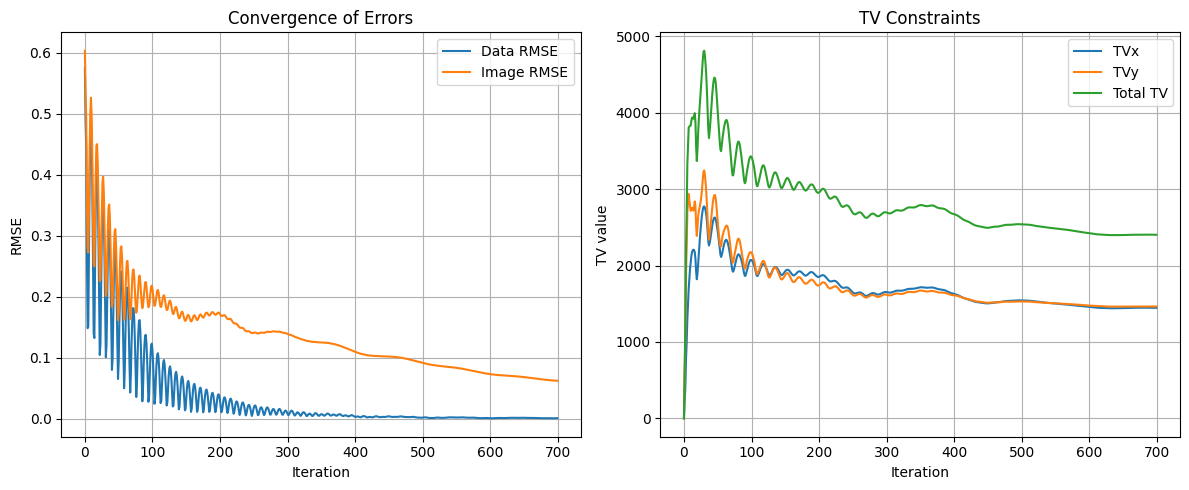

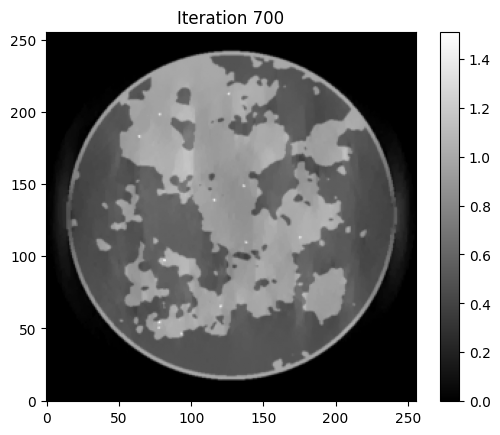

Iter:  800  TVX:  1414.0320895092893  :  1462.1581360343844  TVY:  1441.2468606244963  :  1424.7765859607607  TV:  2355.4489950373327  :  2365.855936721384
derr:  0.001114775508841683  ierr:  0.05572026532798356


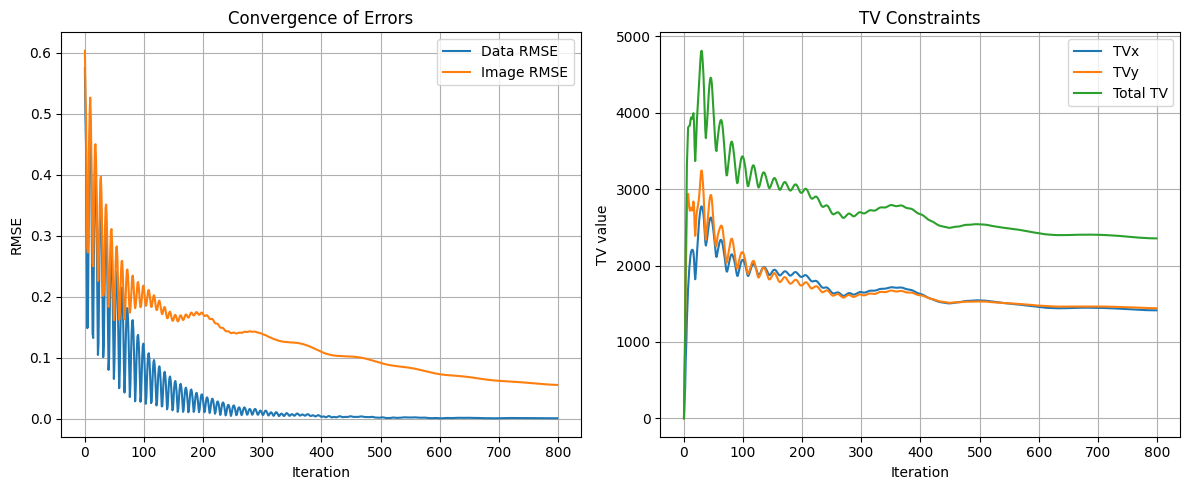

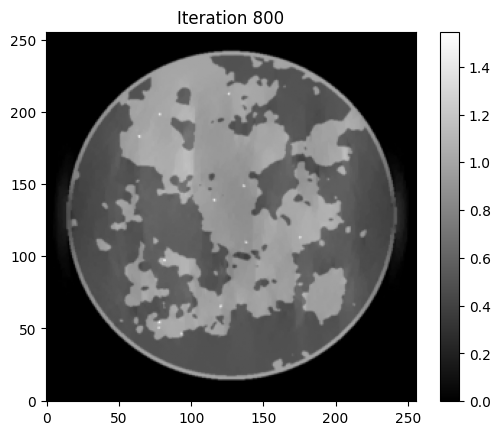

Iter:  900  TVX:  1414.0740879357759  :  1462.1581360343844  TVY:  1439.4167689005646  :  1424.7765859607607  TV:  2352.731735326911  :  2365.855936721384
derr:  0.0010757812036634373  ierr:  0.05136087065539178


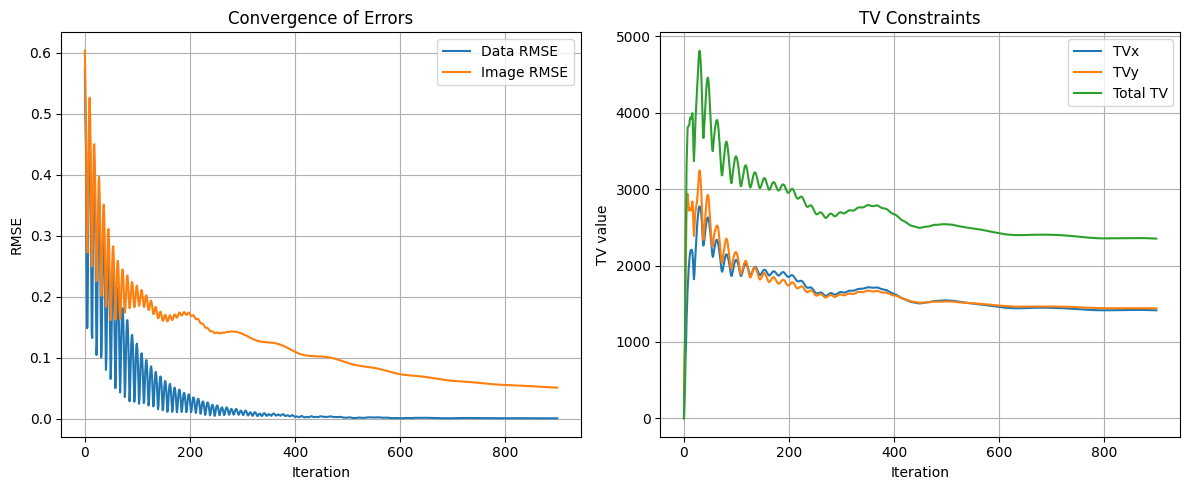

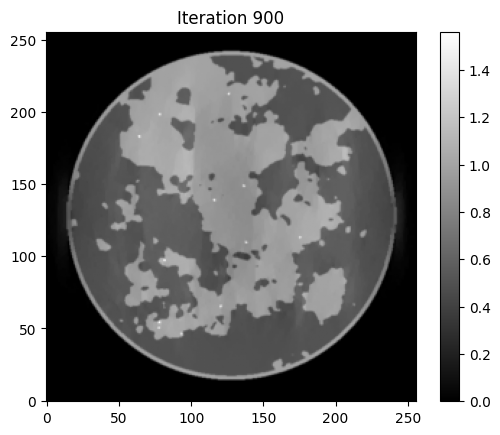

Iter:  1000  TVX:  1403.9372566892794  :  1462.1581360343844  TVY:  1430.1565377142645  :  1424.7765859607607  TV:  2335.4652326292894  :  2365.855936721384
derr:  0.0010554234601245186  ierr:  0.04784390650129045


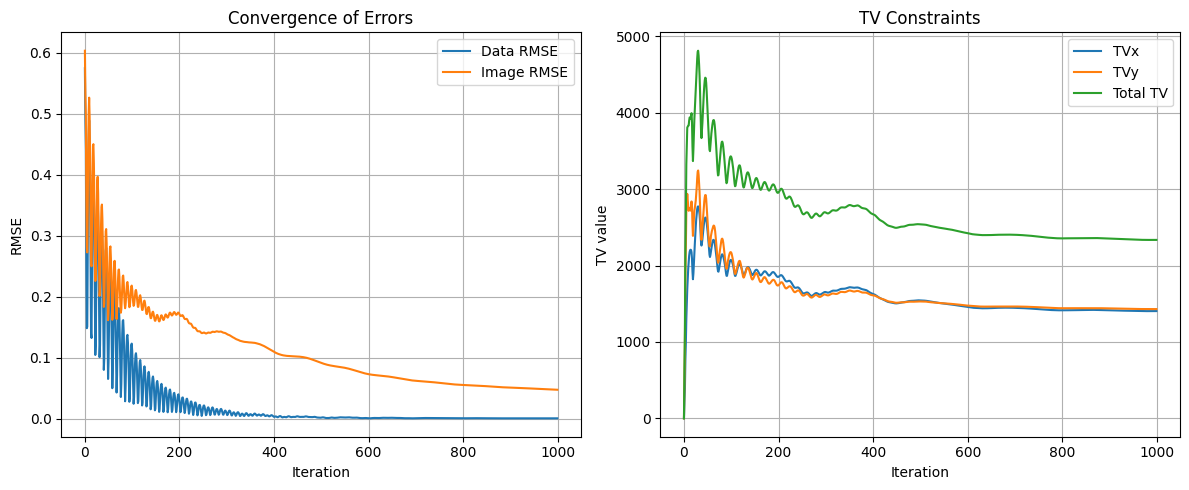

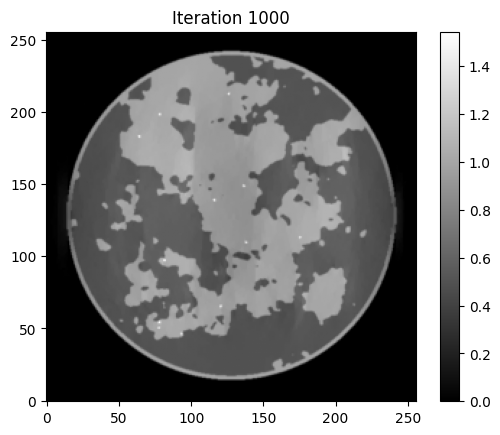

Iter:  1200  TVX:  1400.553335325669  :  1462.1581360343844  TVY:  1425.1967102070605  :  1424.7765859607607  TV:  2326.6090406540106  :  2365.855936721384
derr:  0.0010236005559296846  ierr:  0.039863008113610696


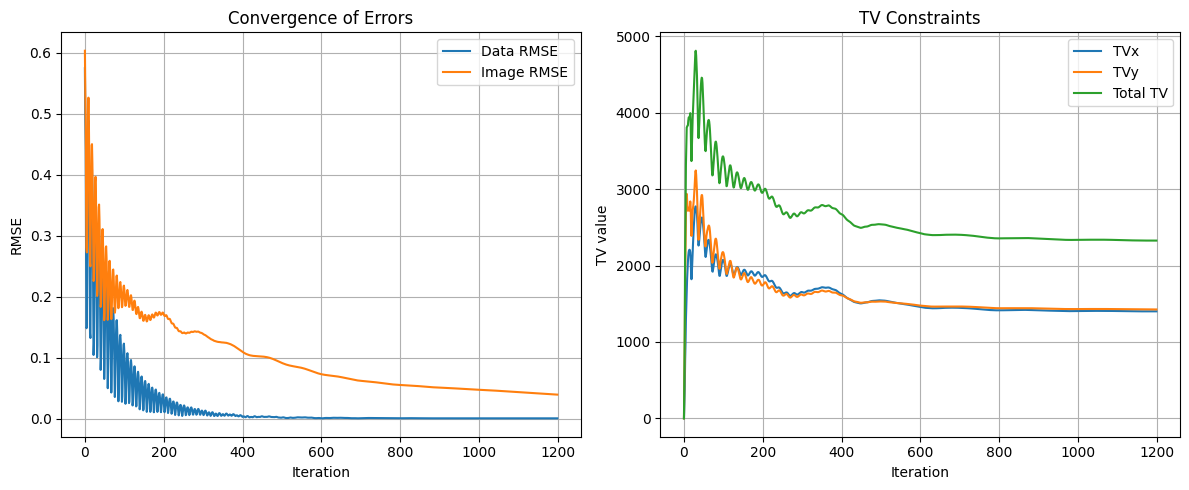

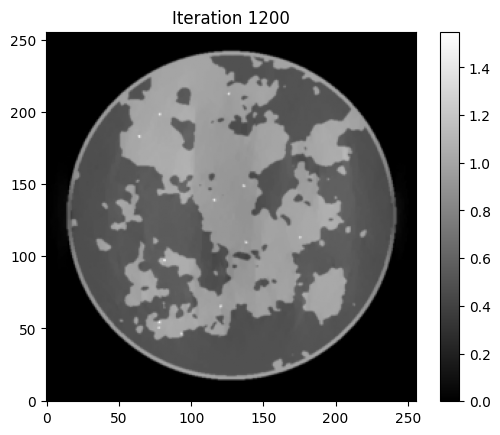

Iter:  1400  TVX:  1398.4663751086548  :  1462.1581360343844  TVY:  1421.0214137307185  :  1424.7765859607607  TV:  2320.089245219589  :  2365.855936721384
derr:  0.0010094093313090615  ierr:  0.031201964095097175


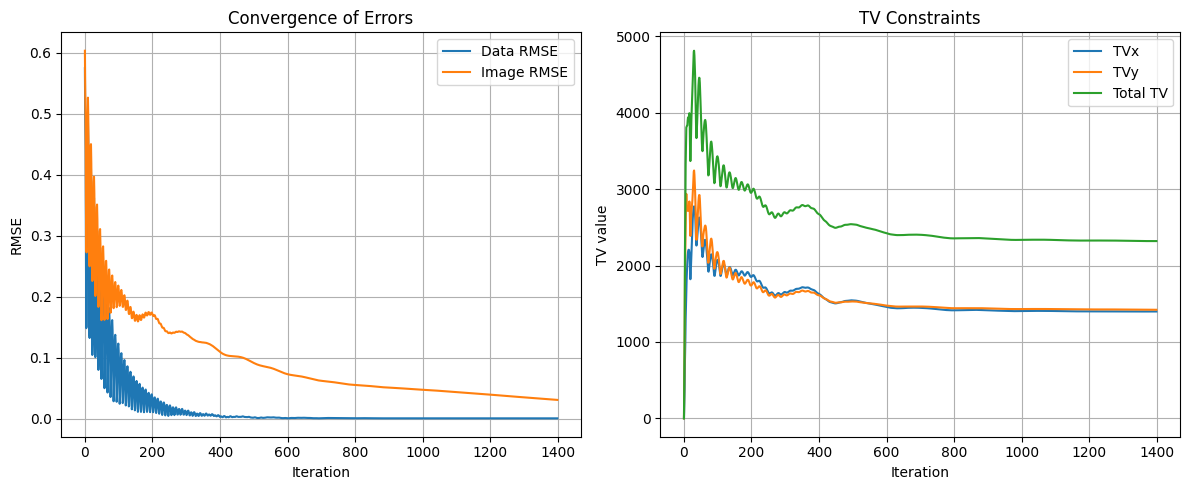

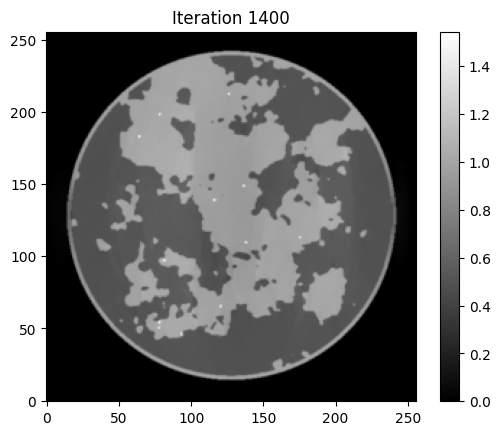

Iter:  1600  TVX:  1399.35054166837  :  1462.1581360343844  TVY:  1418.4342076568369  :  1424.7765859607607  TV:  2317.7965164772813  :  2365.855936721384
derr:  0.0010015071634035032  ierr:  0.02385740673348416


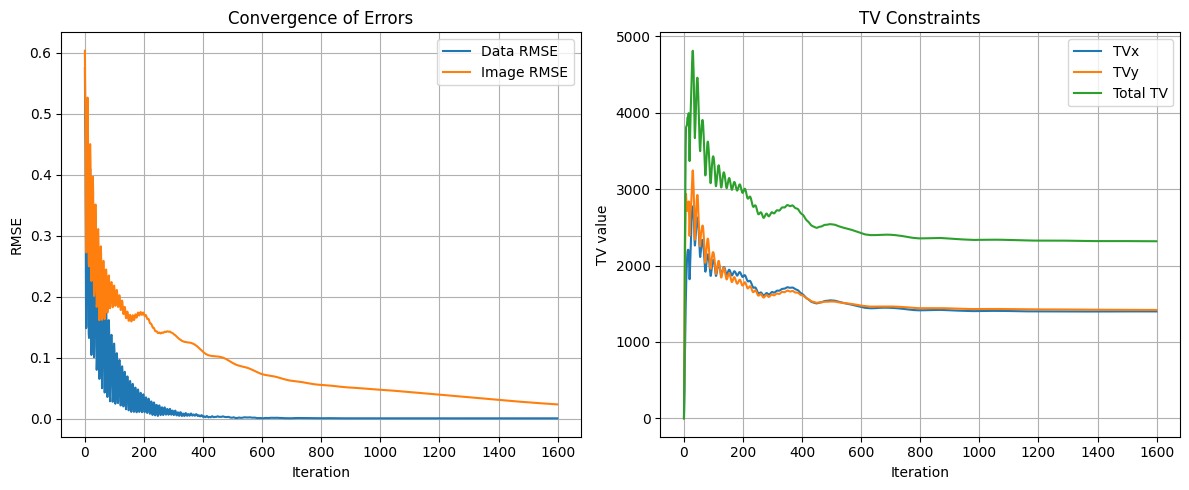

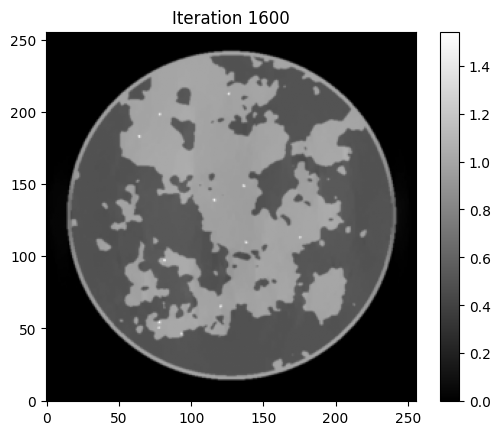

Iter:  1800  TVX:  1399.6719130522106  :  1462.1581360343844  TVY:  1416.9404242708733  :  1424.7765859607607  TV:  2315.9038590270006  :  2365.855936721384
derr:  0.000999816022916517  ierr:  0.01882821214538385


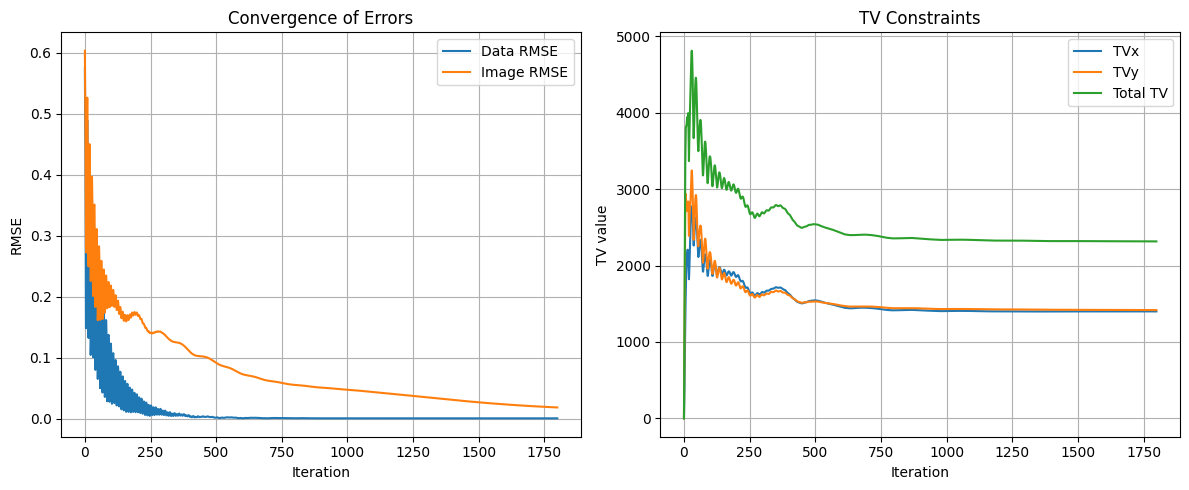

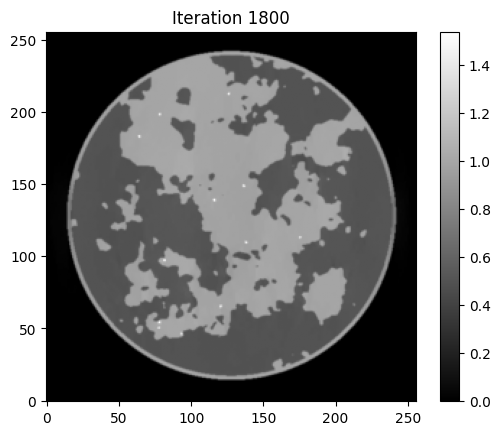

Iter:  2000  TVX:  1401.6356634221656  :  1462.1581360343844  TVY:  1416.0237372835898  :  1424.7765859607607  TV:  2316.0668058753704  :  2365.855936721384
derr:  0.000999385251154616  ierr:  0.016038997670773103


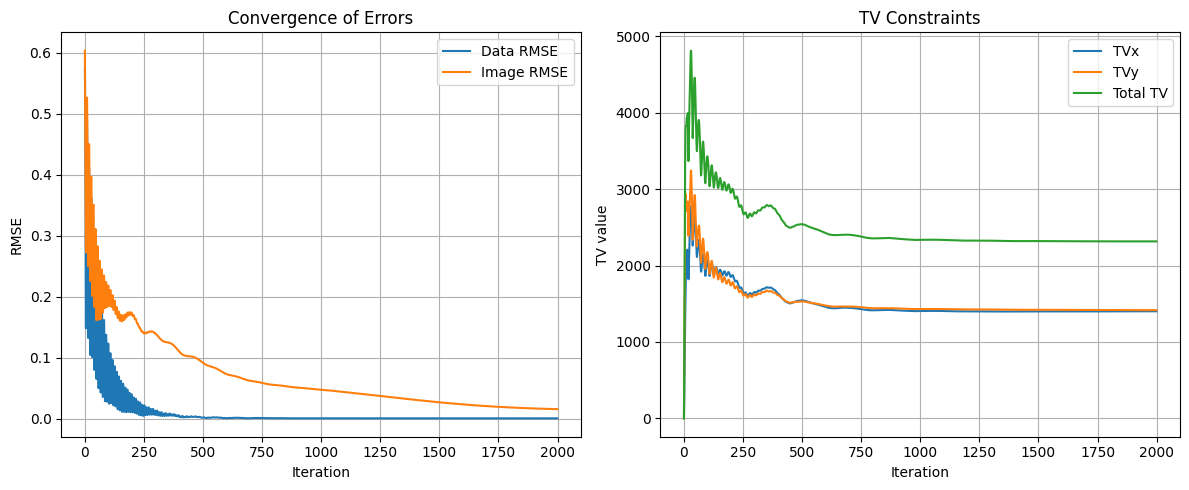

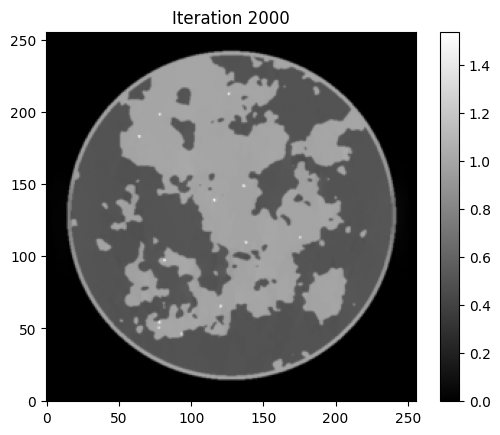

In [27]:
#totalvec = xim*1.
#input("hi")

sig = stepbalance/totalnorm
tau = 1./(totalnorm*stepbalance)

theta = 1.0
itermax = 2000


itr = 0

xim.fill(0.)
yim = xim*0.
xbarim = xim*0.
wimp = xim*0.
wimq = xim*0.
ysino = sinogram*0.
ygradx = testimage*0.
ygrady = testimage*0.
derrs = []
ierrs = []
tvxs = []
tvys = []
tvs = []
istops = [1,2,5,10,20,50,100,200,300,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000,3000,4000,5000]
while itr< itermax:
   itr += 1

   ysinoold = ysino*1.
   ygradxold = ygradx*1.
   ygradyold = ygrady*1.
   yimold = yim*1.

   wimp.fill(0.)
   worksino = fo(ysino)
   circularFanbeamBackProjection(worksino,wimp)
   wimp *= nusino
   wimp *= mask
   wimqx = mdivx(ygradx)
   wimqx *= nuxgrad
   wimqx *= mask
   wimqy = mdivy(ygrady)
   wimqy *= nuygrad
   wimqy *= mask
   wiml1 = l1f*yim

   ximold = xim*1.
   xim = xim -tau*(wimp + wimqx + wimqy + wiml1)
   xim[xim<0.0] = 0.

   xbarim = xim + theta*(xim-ximold)

#data fidelity block
   worksino.fill(0.)
   circularFanbeamProjection(xbarim,worksino)
   worksino = fo(worksino)
   worksino *= nusino
   resid = worksino - sinodatasc
   wdist = sqrt((resid**2).sum())
   wdistn = (wdist/nusino)/sqrt(1.*nviews*nbins)
   derrs.append(wdistn)
   ysino = (ysino + sig*resid)
   ymag = sqrt( (ysino**2).sum() )
   if ymag - sig*nusino*epssc > 0:
      ysino *= (ymag-sig*nusino*epssc)/ymag
   else:
      ysino *= 0.

   tgx = gradx(xbarim)
   tgx *= nuxgrad
   tvc = sqrt((tgx**2)).sum()/nuxgrad
   tvxs.append(tvc)
   ptilx= ygradx + sig*tgx
   ptilmag = maximum(sqrt(ptilx**2 ),(2.-alpha))
   ygradx = (2.-alpha)*ptilx/ptilmag

   tgy = grady(xbarim)
   tgy *= nuygrad
   tvc = sqrt((tgy**2)).sum()/nuygrad
   tvys.append(tvc)
   ptily= ygrady + sig*tgy
   ptilmag = maximum(sqrt(ptily**2 ),(alpha))
   ygrady = alpha*ptily/ptilmag

   tl1 = l1f*xbarim
   ptil1= yim + sig*tl1
   ptilmag = maximum(sqrt(ptil1**2 ),(beta))
   yim = beta*ptil1/maximum(ptilmag,1.e-10)



#TVvals
   tgx,tgy = gradim(xbarim)
   tvc = sqrt((tgx**2 + tgy**2)).sum()
   tvs.append(tvc)



   ygradx = ygradxold - rho*(ygradxold - ygradx)
   ygrady = ygradyold - rho*(ygradyold - ygrady)
   ysino = ysinoold - rho*(ysinoold - ysino)
   yim = yimold - rho*(yimold - yim)
   xim = ximold - rho*(ximold - xim)

   idist = sqrt( ((xbarim-phimage)**2).sum()/ (nx*ny) )
   ierrs.append(idist)
   if itr in istops:
      print("Iter: ",itr," TVX: ",tvxs[-1]," : ",truetvx," TVY: ",tvys[-1]," : ",truetvy," TV: ",tvs[-1]," : ",truetv)
      print("derr: ",derrs[-1], " ierr: ",ierrs[-1])

      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(derrs, label="Data RMSE")
      plt.plot(ierrs, label="Image RMSE")
      plt.xlabel("Iteration")
      plt.ylabel("RMSE")
      plt.legend()
      plt.grid()
      plt.title("Convergence of Errors")
    
      plt.subplot(1, 2, 2)
      plt.plot(tvxs, label="TVx")
      plt.plot(tvys, label="TVy")
      plt.plot(tvs, label="Total TV")
      plt.xlabel("Iteration")
      plt.ylabel("TV value")
      plt.legend()
      plt.grid()
      plt.title("TV Constraints")

      plt.tight_layout()
      plt.show()

      imshow(xbarim.T, cmap='gray', origin='lower')
      title(f"Iteration {itr}")
      colorbar()
      draw()
      pause(0.01)